In [29]:
import json
from matplotlib import pyplot as plt
import numpy as np
import pickle

In [2]:
# load json data from a file
def load_json(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data


def extract_plot(data, gt=None, plotting=False):
    base_x=data[0]["odom"]["pose"]["pose"]['position']['x']
    base_y=data[0]["odom"]["pose"]["pose"]['position']['y']
    points=[]
    for idx in range(len(data)):
        if data[idx]["expmt_flag"]:
            # print(data[idx]["odom"]["pose"]["pose"]['position']['x'])
            x=data[idx]["odom"]["pose"]["pose"]['position']['x']
            y=data[idx]["odom"]["pose"]["pose"]['position']['y']
            points.append([x,y])
            if plotting:
                plt.scatter(x,y, color="blue", s=10)
                plt.text(x, y, str((idx+1)//2), fontsize=10, color="red")

    if plotting:
        # plt.scatter(base_x, base_y, color="green", s=10)
        ax = plt.gca()
        ax.set_aspect('equal', adjustable='box')
        plt.title("Rover location")
        plt.xlim([-2,2])
        plt.ylim([-2,2])
        plt.show()

    # for pIdx in range(1,len(points)):
    #     dist= ((points[pIdx][0]-points[pIdx-1][0])**2+(points[pIdx][1]-points[pIdx-1][1])**2)**0.5
    #     print(f"Distance between {pIdx+1} and {pIdx}: {dist}")
    
    return points
    # err=[]
    # if gt!=None:
    #     for measuredDist, slamLoc in zip(gt[:len(points)], points):
    #         dist= ((slamLoc[0]-t1_pos[0])**2+(slamLoc[1]-t1_pos[1])**2)**0.5
    #         # real_dist=(0.05**2+dist**2)**0.5
    #         real_dist=dist
    #         # print(f"measuredDist: {measuredDist}, Slamdist: {dist}")
    #         err.append((measuredDist-real_dist))
    #     plt.plot(range(1,len(err)+1),err, '.')
    #     plt.ylim([-0.15,0.10])
    #     plt.yticks(np.arange(-0.15, 0.1, 0.01))
    #     plt.xticks(np.arange(1, len(err)+1, 1))
    #     plt.xlabel("Exp stop number")
    #     plt.ylabel("Error")
    #     plt.grid()
    #     plt.show()

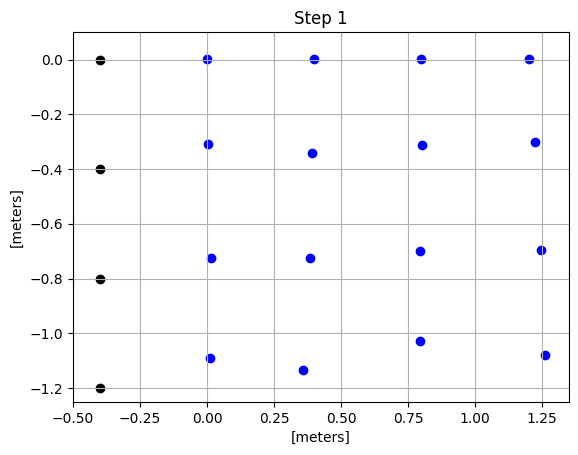

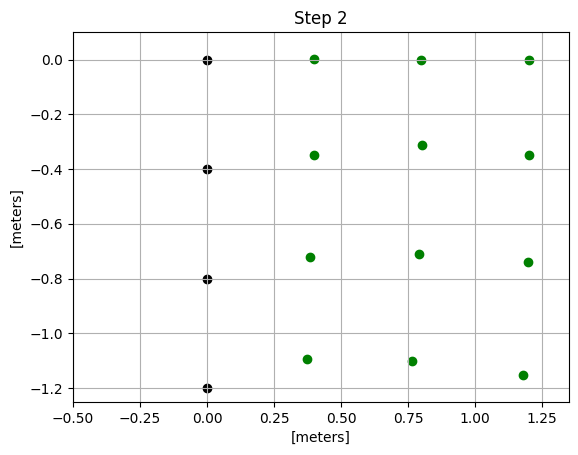

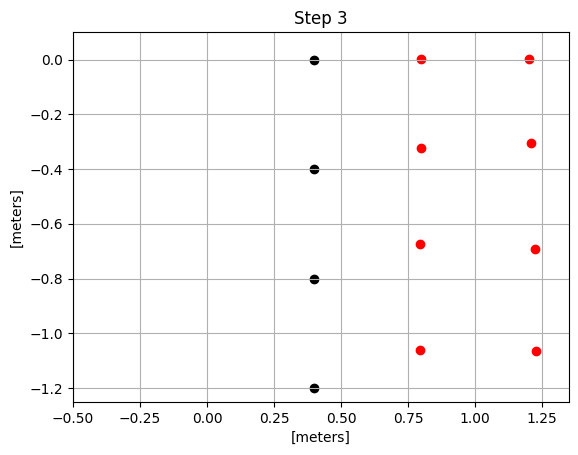

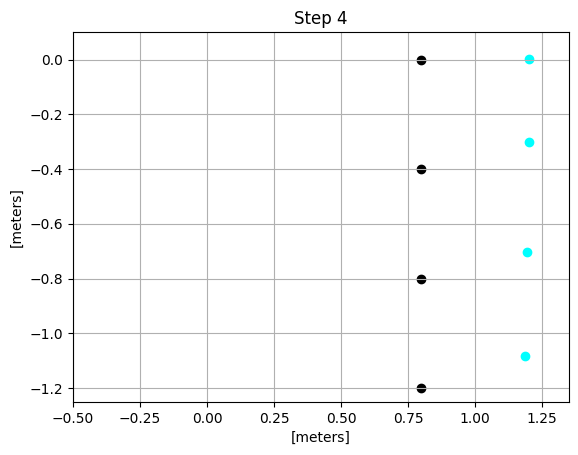

In [25]:
steps=[
    ["FiveTags1_Step1_1", "FiveTags1_Step1_2", "FiveTags1_Step1_3", "FiveTags1_Step1_4"],  
    ["FiveTags1_Step2_1", "FiveTags1_Step2_2", "FiveTags1_Step2_3"],
    ["FiveTags1_Step3_1", "FiveTags1_Step3_2"],
    ["FiveTags1_Step4_1",],
]
colors=['blue', 'green', 'red', 'cyan']
static_tag_init_locs=[
    (-0.4, 0),
    (-0.4,-0.4),
    (-0.4,-0.8),
    (-0.4,-1.2),
]

loaded_data={} #{<step_name>: [coordinates, (x_offset, y_offset)]}
links=[]
distances={} # {step_no: {exp_np: {"t1-t2": distance}}}

for step_idx, step in enumerate(steps):
    plt.figure()
    exp_no=0
    distances[step_idx+1]={}
    for line_idx, line in enumerate(step):
        coordinates=extract_plot(load_json(f"RoverData/{line}/{line}.json"),plotting=False)
        offset=((step_idx+line_idx)*0.4,0)
        loaded_data[line]=[coordinates, offset]
        # print(len(coordinates),coordinates)
        for x,y in coordinates:
            plt.scatter(x+offset[0],y+offset[1],color=colors[step_idx])
    
            # Link of this current position of rover tag with all the static tags
            for static_tag_idx, static_tag_locs in enumerate(static_tag_init_locs):
                static_x, static_y = static_tag_locs
                links.append([static_x+step_idx*0.4, static_y, x+offset[0],y+offset[1]])
                if exp_no not in distances[step_idx+1]:
                    distances[step_idx+1][exp_no] = {}    
                t_x=static_tag_idx+1
                key_str=f"{t_x}-5"
                distances[step_idx+1][exp_no][key_str] = np.linalg.norm(np.array([static_x+step_idx*0.4, static_y,])-np.array([x+offset[0],y+offset[1]]))
            exp_no+=1
                
    for x,y in static_tag_init_locs:
        plt.scatter(x+step_idx*0.4,y,color='black')
        
    # Inter-staticTag links
    for static1_idx, static1_coord in enumerate(static_tag_init_locs):
        for static2_idx, static2_coord in enumerate(static_tag_init_locs):
            if static1_idx==static2_idx:
                continue
            links.append([static1_coord[0]+step_idx*0.4, static1_coord[1], static2_coord[0]+step_idx*0.4, static2_coord[1]])
        
    plt.xlim([-0.5,1.35])
    plt.ylim([-1.25,0.1])
    plt.title(f"Step {step_idx+1}")
    plt.ylabel("[meters]")
    plt.xlabel("[meters]")
    plt.grid()
    plt.show()

# Inter-staticTag links for step 5
for static1_idx, static1_coord in enumerate(static_tag_init_locs):
    for static2_idx, static2_coord in enumerate(static_tag_init_locs):
        if static1_idx==static2_idx:
            continue
        links.append([static1_coord[0]+4*0.4, static1_coord[1], static2_coord[0]+4*0.4, static2_coord[1]])

In [31]:
with open("distances.pkl", 'wb') as f:
    pickle.dump(distances,f)

220


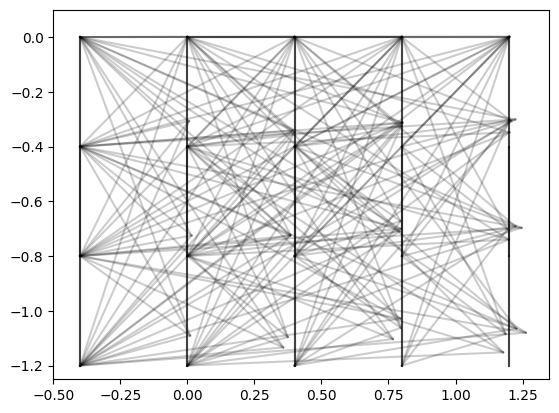

In [4]:
print(len(links))
for x1, y1, x2, y2 in links:
    plt.plot([x1, x2], [y1, y2], alpha=0.2, color='black')

plt.xlim([-0.5,1.35])
plt.ylim([-1.25,0.1])
plt.show()
